In [ ]:
!pip install transformers -q

In [ ]:
import os
import re
import csv
import glob
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

from transformers import T5Tokenizer, T5ForConditionalGeneration

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

%autosave 60

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Autosaving every 60 seconds


In [ ]:
!nvidia-smi

Sat Aug  8 16:43:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# # Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

#Download and read data


In [ ]:
cd drive/My Drive/lab

/content/drive/My Drive/lab


In [ ]:
## go into folder with data and unzip
# !unzip BBC\ News\ Summary.zip


path_to_articles = '/content/lab/BBC News Summary/News Articles'
path_to_summaries = '/content/lab/BBC News Summary/Summaries'

path_to_amazon_reviews = 'Reviews.csv'

In [ ]:
# Parse all the files
input_files = []
for root, dirs, files in os.walk(path_to_articles):
    for file_ in files:
        path = os.path.join(root, file_)
        input_files.append(path) 

In [ ]:
# Read file
def read_file(main_df):
    import csv
    df_test = pd.DataFrame(columns=['ctext', 'ctext_name'])
    for file_path in input_files:
        df = pd.read_csv(file_path, sep = "/n", header = None, quoting=csv.QUOTE_NONE)
        df = df.transpose()

        file_path_to_sum = file_path.replace("News Articles", "Summaries")

        df2 = pd.read_csv(file_path_to_sum, sep = "/n", header = None, quoting=csv.QUOTE_NONE)
        df2 = df2.transpose()

        df2['ctext'] = df2.apply(lambda x: '\n'.join(x.dropna().astype(str)), axis=1)
        df2.drop(df2.columns[:-1], axis=1, inplace=True)

        df2["ctext_name"] = '/'.join(file_path_to_sum.split('/')[-2:])

        df["text"] = df.apply(lambda x: '\n'.join(x.dropna().astype(str)), axis=1)
        df.drop(df.columns[:-1], axis=1, inplace=True)

        df["label"] = file_path.split('/')[-2]

        df["doc_name"] = '/'.join(file_path.split('/')[-2:])

        main_df = pd.concat([main_df, df], ignore_index=True)
        df_test = pd.concat([df_test, df2], ignore_index=True)

    main_df['ctext'] = df_test['ctext']
    main_df['ctext_name'] = df_test['ctext_name']

    return main_df

In [ ]:
df_news = pd.DataFrame(columns=['text','label','doc_name', 'ctext','ctext_name', 'clean_text', 'clean_ctext', 'clean_ctext_sec2'])
df_news = read_file(df_news)
df_news = shuffle(df_news)
df_news.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


,text,label,doc_name,ctext,ctext_name,clean_text,clean_ctext,clean_ctext_sec2
1558,Lee to create new film superhero\nComic book v...,entertainment,entertainment/374.txt,A third Spider-Man film is scheduled for relea...,entertainment/374.txt,NaN,NaN,NaN
1361,IAAF launches fight against drugs\nThe IAAF - ...,sport,sport/004.txt,"""I am very happy to see you all, members of th...",sport/004.txt,NaN,NaN,NaN
29,'No UK apology' for colonial past\nThe days of...,politics,politics/392.txt,Mr Brown has signed a debt relief deal with Ta...,politics/392.txt,NaN,NaN,NaN
925,Salary scandal in Cameroon\nCameroon says wide...,business,business/133.txt,The prime minister's office said the alleged f...,business/133.txt,NaN,NaN,NaN
1349,Umaga ready for Lions\nAll Blacks captain Tama...,sport,sport/328.txt,"But Umaga, in England for Saturday's IRB Rugby...",sport/328.txt,NaN,NaN,NaN


In [ ]:
df_reviews_ = pd.read_csv(path_to_amazon_reviews)
# df_reviews_.head()
_df_reviews = pd.DataFrame(columns=['text','sum'])
_df_reviews['text'] = df_reviews_['Text']
_df_reviews['sum'] = df_reviews_['Summary']
_df_reviews.head()

,text,sum
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [ ]:
is_NaN = _df_reviews.isnull()

row_has_NaN = is_NaN.any(axis=1)

rows_with_NaN = _df_reviews[row_has_NaN]

In [ ]:
nans_indexs = rows_with_NaN.index.to_list() # list of row indexes contain nans 

print(f'Before dropping {_df_reviews.shape}')

df_reviews = _df_reviews.drop(nans_indexs)

print(f'After dropping {df_reviews.shape}')

Before dropping (568454, 2)
After dropping (568427, 2)


#Data preparation


### Clean data

In [ ]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [ ]:
df_news.head()

,text,label,doc_name,ctext,ctext_name,clean_text,clean_ctext,clean_ctext_sec2
1558,lee create new film superhero comic book veter...,entertainment,entertainment/374.txt,third spiderman film scheduled release 2007 . ...,entertainment/374.txt,NaN,NaN,NaN
1361,iaaf launches fight drugs iaaf athletics worl...,sport,sport/004.txt,i happy see all members athletics family respo...,sport/004.txt,NaN,NaN,NaN
29,no uk apology colonial past days britain apolo...,politics,politics/392.txt,mr brown signed debt relief deal tanzania coul...,politics/392.txt,NaN,NaN,NaN
925,salary scandal cameroon cameroon says widespre...,business,business/133.txt,prime minister office said alleged fraud uncov...,business/133.txt,NaN,NaN,NaN
1349,umaga ready lions blacks captain tama umaga wa...,sport,sport/328.txt,umaga england saturday irb rugby aid match als...,sport/328.txt,NaN,NaN,NaN


In [ ]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [ ]:
# Clean the summaries and texts
clean_summaries = []
for summary in df_reviews['sum']:
    clean_summaries.append(clean_text(summary, remove_stopwords=False))
print("Summaries are complete.")

clean_texts = []
for text in df_reviews['text']:
    clean_texts.append(clean_text(text))
print("Texts are complete.")

Summaries are complete.
Texts are complete.


In [ ]:
df_reviews_clean = pd.DataFrame(columns=['clean_text', 'clean_sum'])

df_reviews_clean['clean_sum'] = clean_summaries
df_reviews_clean['clean_text'] = clean_texts

In [ ]:
df_reviews_clean.head()

,clean_text,clean_sum
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,confection around centuries light pillowy citr...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great taffy great price wide assortment yummy ...,great taffy


In [ ]:
import re

#Removes non-alphabetic characters:
def clean_col(column):
    for row in column:
        
        row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        
        row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively
        
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!
        
        row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM
        
        
        row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)
        
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        
        #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them
        
        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces
        
        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        yield row

In [ ]:
pre_clean_text = clean_col(df_news['text'])
pre_clean_ctext1 = clean_col(df_news['ctext'])
pre_clean_ctext2 = clean_col(df_news['ctext'])

In [ ]:
pre_clean_review_text = clean_col(df_reviews['text'])
pre_clean_review_sum1 = clean_col(df_reviews['sum'])
pre_clean_review_sum2 = clean_col(df_reviews['sum'])

In [ ]:
from time import time
import spacy
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:
t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
clean_text = [str(doc) for doc in nlp.pipe(pre_clean_text, batch_size=5000, n_threads=-1)]
df_news['clean_text']= clean_text

print('Time to clean up text: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up text: 19.43 mins


In [ ]:
#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:
t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
clean_ctext_sec2 = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(pre_clean_ctext1, batch_size=5000, n_threads=-1)]
clean_ctext = [str(doc) for doc in nlp.pipe(pre_clean_ctext2, batch_size=5000, n_threads=-1)]

df_news['clean_ctext_sec2']= clean_ctext_sec2
df_news['clean_ctext']= clean_ctext


print('Time to clean up ctext: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up ctext: 4.22 mins


In [ ]:
df_news.head()

,text,label,doc_name,ctext,ctext_name,clean_text,clean_ctext,clean_ctext_sec2
1629,"Prime minister's questions\nSo who, if anyone,...",politics,politics/326.txt,The prime minister claims this is the clearest...,politics/326.txt,prime minister questions so who if anyone is p...,the prime minister claims this is the clearest...,_START_ the prime minister claims this is the ...
680,"Rover deal 'may cost 2,000 jobs'\nSome 2,000 j...",business,business/034.txt,But Rover told BBC News that reports of job cu...,business/034.txt,rover deal may cost 000 jobs some 000 jobs at ...,but rover told bbc news that reports of job cu...,_START_ but rover told bbc news that reports o...
1980,Apple Mac mini gets warm welcome\nThe Mac mini...,tech,tech/300.txt,"But, he said, the Mac mini changed that percep...",tech/300.txt,apple mac mini gets warm welcome the mac mini ...,but he said the mac mini changed that percepti...,_START_ but he said the mac mini changed that ...
1572,New UKIP defection to 'Veritas'\nThe UK Indepe...,politics,politics/288.txt,Damian Hockney said ex-chatshow host Mr Kilroy...,politics/288.txt,new ukip defection to veritas the uk independe...,damian hockney said ex-chatshow host mr kilroy...,_START_ damian hockney said ex-chatshow host m...
451,Japan narrowly escapes recession\nJapan's econ...,business,business/006.txt,"On an annual basis, the data suggests annual g...",business/006.txt,japan narrowly escapes recession japan economy...,on an annual basis the data suggests annual gr...,_START_ on an annual basis the data suggests a...


In [ ]:
#Check how much % of text have <= 800 words
cnt=0
for i in df_news['clean_text']:
    if(len(i.split())<=1000):
        cnt=cnt+1
print("Text News: {}".format(cnt/len(df_news['clean_text'])))

#Check how much % of summary have <= 350 words
cnt=0
for i in df_news['clean_ctext']:
    if(len(i.split())<=500):
        cnt=cnt+1
print("Summary News: {}".format(cnt/len(df_news['clean_ctext'])))

#Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len_news=1000
max_summary_len_news=500


In [ ]:
#Delete stop words

stop_words = set(stopwords.words('english'))

filtered_sentences = []
for text_index in range(len(df_news)): 
  word_tokens = word_tokenize(df_news['clean_text'][text_index])
  filtered_sentence = [w for w in word_tokens if not w in stop_words] 
  filtered_sentences.append([filtered_sentence])

df_news_cleaned = pd.DataFrame(columns=['cleaned_text'], data=filtered_sentences)
df_news_cleaned['label'] = df_news['label']

df_news_cleaned.head()

,cleaned_text,label
0,"[ethnic, producers, face, barriers, minority, ...",entertainment
1,"[jail, singer, courtney, love, singer, courtne...",entertainment
2,"[us, show, sued, rat-eating, stunt, us, tv, ne...",entertainment
3,"[snicket, tops, us, box, office, chart, film, ...",entertainment
4,"[us, composer, recreates, bach, score, us, mus...",entertainment


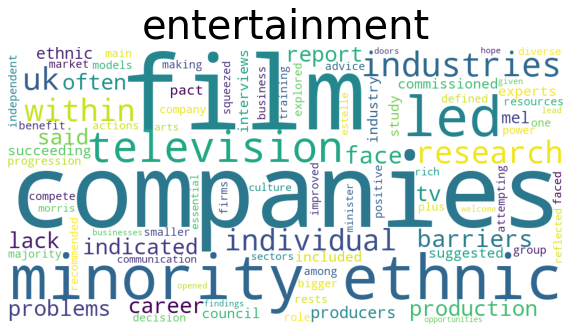

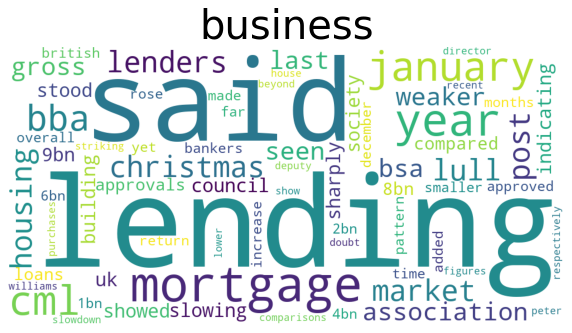

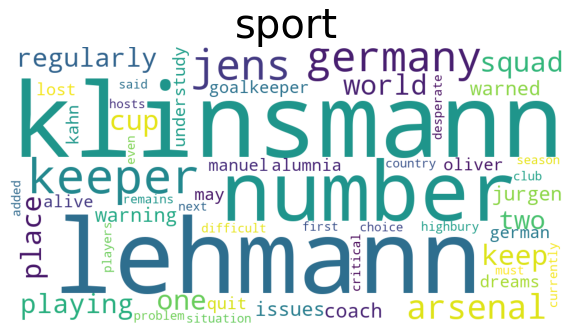

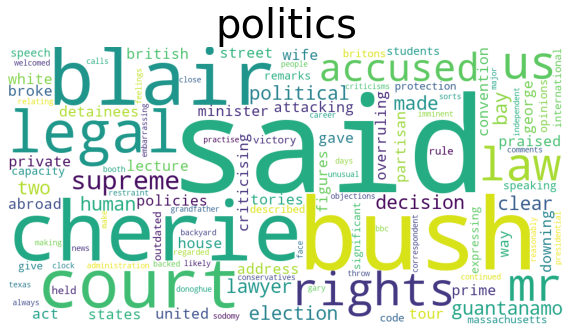

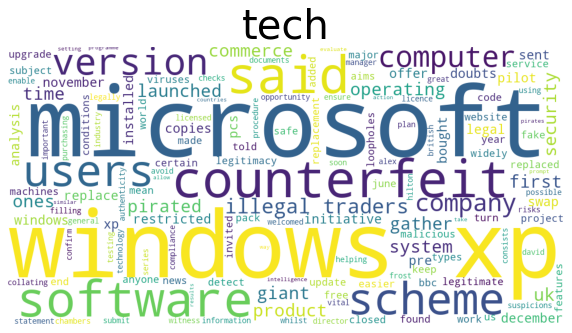

In [ ]:
# !pip install --user wordcloud
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from os import path
%matplotlib inline

categories = df_news_cleaned.label.unique()

for category in categories:

  wordcloud = WordCloud(background_color="white", width=1000, height=500).generate(
      ' '.join(df_news_cleaned[df_news_cleaned.label == category]['cleaned_text'].reset_index(drop=True)[0])
      )
    
  plt.figure(figsize=(10,7))
  plt.imshow(wordcloud)
  plt.title(f"{category}", fontsize=40)
  plt.axis("off")
  plt.show()

#T5 Model


In [ ]:
# Creating a custom dataset for reading the dataframe and loading it into the dataloader 
  #to pass it to the neural network at a later stage for finetuning  the model and to prepare it for predictions

class DatasetPreparation(Dataset):

    def __init__(self, dataframe, tokenizer, source_len, summ_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.summ_len = summ_len
        self.text = self.data.clean_text
        self.ctext = self.data.clean_sum

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        ctext = str(self.ctext[index])
        ctext = ' '.join(ctext.split())

        text = str(self.text[index])
        text = ' '.join(text.split())

        source = self.tokenizer.batch_encode_plus([ctext], max_length= self.source_len, pad_to_max_length=True,return_tensors='pt')
        target = self.tokenizer.batch_encode_plus([text], max_length= self.summ_len, pad_to_max_length=True,return_tensors='pt')

        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        return {
            'source_ids': source_ids.to(dtype=torch.long), 
            'source_mask': source_mask.to(dtype=torch.long), 
            'target_ids': target_ids.to(dtype=torch.long),
            'target_ids_y': target_ids.to(dtype=torch.long)
        }



In [ ]:
# Creating the training function. This will be called in the main function. It is run depending on the epoch value.
# The model is put into train mode and then we wnumerate over the training loader and passed to the defined network 

def train(epoch, tokenizer, model, device, loader, optimizer):
    model.train()
    for _,data in enumerate(loader, 0):
        y = data['target_ids'].to(device, dtype = torch.long)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data['source_ids'].to(device, dtype = torch.long)
        mask = data['source_mask'].to(device, dtype = torch.long)

        outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, lm_labels=lm_labels)
        loss = outputs[0]
        
        if _%500==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
def validate(epoch, tokenizer, model, device, loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)

            generated_ids = model.generate(
                input_ids = ids,
                attention_mask = mask, 
                max_length=150, 
                num_beams=2,
                repetition_penalty=2.5, 
                length_penalty=1.0, 
                early_stopping=True
                )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
            if _%100==0:
                print(f'Completed {_}')

            predictions.extend(preds)
            actuals.extend(target)
    return predictions, actuals

In [ ]:
df = df_reviews[['clean_text','clean_sum1']]
df

,clean_text,clean_sum1
0,i have bought several of the vitality canned d...,good quality dog food
1,product arrived labeled as jumbo salted peanut...,not as advertised
2,this is confection that has been around few ce...,delight says it all
3,if you are looking for the secret ingredient i...,cough medicine
4,great taffy at great price there was wide asso...,great taffy
...,...,...
86984,i first got introduced to the greenies brand w...,like bees to honey
86985,this is regular item on my shopping list now t...,my dogs love them
86986,my small dogs love these it keeps their breath...,my dogs love greenies
86987,greenies tries to position itself as healthy t...,dogs love them but they re not healthy


In [ ]:
# df = df_reviews[['clean_text','clean_sum']]
df.loc[:, :'clean_text']

,clean_text
0,bought several vitality canned dog food produc...
1,product arrived labeled jumbo salted peanuts p...
2,confection around centuries light pillowy citr...
3,looking secret ingredient robitussin believe f...
4,great taffy great price wide assortment yummy ...
...,...
568449,great sesame chicken good better resturants ea...
568450,disappointed flavor chocolate notes especially...
568451,stars small give 10 15 one training session tr...
568452,best treats training rewarding dog good groomi...


In [ ]:
def main():

    TRAIN_BATCH_SIZE = 2    # input batch size for training (default: 64)
    VALID_BATCH_SIZE = 2    # input batch size for testing (default: 1000)
    TRAIN_EPOCHS = 2        # number of epochs to train (default: 10)
    VAL_EPOCHS = 1 
    LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
    SEED = 42               # random seed (default: 42)
    MAX_LEN = 1000
    SUMMARY_LEN = 500 

    # Set random seeds and deterministic pytorch for reproducibility
    torch.manual_seed(SEED) # pytorch random seed
    np.random.seed(SEED) # numpy random seed
    torch.backends.cudnn.deterministic = True

    # tokenzier for encoding the text
    tokenizer = T5Tokenizer.from_pretrained("t5-base")
    
    # Selecting the needed columns only and shuffle them.

    df = df_news[['text','ctext']]
    df.ctext = 'summarize: ' + df.ctext
    print(df.head())

    
    # Creation of Dataset and Dataloader
    # Defining the train size. So 80% of the data will be used for training and the rest will be used for validation. 
    train_size = 0.8
    train_dataset=df.sample(frac=train_size, random_state = SEED).reset_index(drop=True)
    val_dataset=df.drop(train_dataset.index).reset_index(drop=True)

    print("FULL Dataset: {}".format(df.shape))
    print("TRAIN Dataset: {}".format(train_dataset.shape))
    print("TEST Dataset: {}".format(val_dataset.shape))


    # Creating the Training and Validation dataset for further creation of Dataloader
    training_set = DatasetPreparation(train_dataset, tokenizer, MAX_LEN, SUMMARY_LEN)
    val_set = DatasetPreparation(val_dataset, tokenizer, MAX_LEN, SUMMARY_LEN)

    # Defining the parameters for creation of dataloaders
    train_params = {
        'batch_size': TRAIN_BATCH_SIZE,
        'shuffle': True,
        'num_workers': 0
        }

    val_params = {
        'batch_size': VALID_BATCH_SIZE,
        'shuffle': False,
        'num_workers': 0
        }

    # Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)

    
    # Defining the model. We are using t5-base model and added a Language model layer on top for generation of Summary. 
    # Further this model is sent to device (GPU/TPU) for using the hardware.
    model = T5ForConditionalGeneration.from_pretrained("t5-base")
    model = model.to(device)

    # Defining the optimizer that will be used to tune the weights of the network in the training session. 
    optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

    # Training loop
    print('Initiating Fine-Tuning for the model on our dataset')

    for epoch in range(TRAIN_EPOCHS):
        train(epoch, tokenizer, model, device, training_loader, optimizer)


    # Validation loop and saving the resulting file with predictions and acutals in a dataframe.
    # Saving the dataframe as predictions.csv
    print('Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe')
    for epoch in range(VAL_EPOCHS):
        predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
        final_df = pd.DataFrame({'Generated Text':predictions,'Actual Text':actuals})
        final_df.to_csv('predictions_t5.csv')
        print('Output Files generated for review')

if __name__ == '__main__':
    main()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


                                                   text                                              ctext
1629  Prime minister s questions So who  if anyone  ...  summarize: The prime minister claims this is t...
680   Rover deal  may cost 2 000 jobs  Some 2 000 jo...  summarize: But Rover told BBC News that report...
1980  Apple Mac mini gets warm welcome The Mac mini ...  summarize: But, he said, the Mac mini changed ...
1572  New UKIP defection to  Veritas  The UK Indepen...  summarize: Damian Hockney said ex-chatshow hos...
451   Japan narrowly escapes recession Japan s econo...  summarize: On an annual basis, the data sugges...
FULL Dataset: (2225, 2)
TRAIN Dataset: (1780, 2)
TEST Dataset: (445, 2)
Initiating Fine-Tuning for the model on our dataset
Epoch: 0, Loss:  14.032540321350098
Epoch: 0, Loss:  2.950718641281128
Epoch: 1, Loss:  2.8506920337677
Epoch: 1, Loss:  2.0221173763275146
Now generating summaries on our fine tuned model for the validation dataset and saving it in a

#Seq2Seq Model


In [ ]:
#Select the Summaries and Text between max len defined above

cleaned_text =np.array(df_news['clean_text'])
cleaned_summary=np.array(df_news['clean_ctext_sec2'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'ctext':short_summary})

#Add sostok and eostok at 
post_pre['ctext'] = post_pre['ctext'].apply(lambda x : 'sostok '+ x + ' eostok')
post_pre.head()

,text,ctext
0,johnny and denise lose passport johnny vaughan and denise van outen saturday night entertainment show passport to paradise will not return to screens the bbc has said the ex-big breakfast presente...,sostok _START_ johnny vaughan and denise van outen saturday night entertainment show passport to paradise will not return to screens the bbc has said.the bbc spokeswoman said graham norton strictl...
1,us adds more jobs than expected the us economy added 337 000 jobs in october seven-month high and far more than wall street expectations in welcome economic boost for newly re-elected president ge...,sostok _START_ the 337 000 new jobs added to us payrolls in october was twice the 169 000 figure that wall street economists had forecast.the us economy added 337 000 jobs in october seven-month h...
2,laura ashley chief stepping down laura ashley is parting company with its chief executive ainum mohd-saaid the clothing and home furnishing retailer said ms mohd-saaid had resigned for personal re...,sostok _START_ laura ashley is parting company with its chief executive ainum mohd-saaid.in statement issued on thursday laura ashley thanked ms mohd-saaid for her services to the company.ms mohd-...
3,fit-again betsen in france squad france have brought flanker serge betsen back into their squad to face england at twickenham on sunday but the player who missed the victory over scotland through ...,sostok _START_ serge has good case so we are confident he will play said france coach bernard laporte.france regular back-row combination of betsen harinordoquy and olivier magne were all missing...
4,us data sparks inflation worries wholesale prices in the us rose at the fastest rate in more than six years in january according to government data new figures show the labor department producer p...,sostok _START_ the university index of consumer spending fell to 94.2 in early february from 95.5 in january which could indicate fall in retail spending by the us public the ppi would argue for g...


In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split( np.array(post_pre['text']), np.array(post_pre['ctext']) ,test_size=0.2, random_state=42, shuffle=False)

In [ ]:
print("FULL Dataset: {}".format(post_pre.shape))
print("TRAIN Dataset: {}".format(len(X_train)))
print("TEST Dataset: {}".format(len(X_test)))

FULL Dataset: (2206, 2)
TRAIN Dataset: 1764
TEST Dataset: 442


In [ ]:
#Prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(X_train))


thresh = 4

cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt+1
    tot_freq = tot_freq+value
    if(value < thresh):
        cnt = cnt + 1
        freq = freq + value
    
print("% of rare words in vocabulary:", (cnt/tot_cnt) * 100)
print("Total Coverage of rare words:", (freq/tot_freq) * 100)

% of rare words in vocabulary: 58.59908668905914
Total Coverage of rare words: 3.692897283045002


In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) After building the model, it needs to be compiled and trained which is achieved by Model.compile and Model.fit keras models functional methods. Model training is performed by tuning various hyperparameters such as

epochs,
 optimizer, 
batch size,
 embedding dimension, 
activation,
 lossfunction 
learning rate 
 variations 
in the accuracy and loss values are determined and analyzed. After training phase comes the inference phase, in which we input the testing data to our model and get the output predicted summary. 
#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq  = x_tokenizer.texts_to_sequences(X_train) 
x_val_seq = x_tokenizer.texts_to_sequences(X_test)

#padding zero upto maximum length
X_train   = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
X_test    = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
X_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(X_voc))


Size of vocabulary in X = 10971


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))

thresh = 6

cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt+1
    tot_freq = tot_freq+value
    if(value < thresh):
        cnt = cnt + 1
        freq = freq + value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 72.49107388080198
Total Coverage of rare words: 8.498418568109935


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_train))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_train) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_test) 

#padding zero upto maximum length
y_train    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_test   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))



Size of vocabulary in Y = 5009


In [ ]:
from tensorflow.keras import backend as K
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(X_voc))

K.clear_session()

latent_dim = 256
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(X_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Size of vocabulary from the w2v model = 10971
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1000, 200)    2194200     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 1000, 256),  467968      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
history = model.fit(
    [X_train, y_train[:,:-1]],
    y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,
    epochs=25,
    callbacks=[es],
    batch_size=64, 
    validation_data=([X_test,y_test[:,:-1]], 
                     y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:])
    )

Epoch 1/25
28/28 [==============================] - 283s 10s/step - loss: 3.2963 - val_loss: 2.2382
Epoch 2/25
28/28 [==============================] - 285s 10s/step - loss: 2.2026 - val_loss: 1.9972
Epoch 3/25
28/28 [==============================] - 286s 10s/step - loss: 2.0514 - val_loss: 1.9688
Epoch 4/25
28/28 [==============================] - 283s 10s/step - loss: 2.0289 - val_loss: 1.9506
Epoch 5/25
28/28 [==============================] - 281s 10s/step - loss: 2.0037 - val_loss: 1.9256
Epoch 6/25
28/28 [==============================] - 278s 10s/step - loss: 1.9750 - val_loss: 1.9043
Epoch 7/25
28/28 [==============================] - 279s 10s/step - loss: 1.9531 - val_loss: 1.8914
Epoch 8/25
28/28 [==============================] - 278s 10s/step - loss: 1.9343 - val_loss: 1.8752
Epoch 9/25
28/28 [==============================] - 278s 10s/step - loss: 1.9184 - val_loss: 1.8622
Epoch 10/25
28/28 [==============================] - 281s 10s/step - loss: 1.9012 - val_loss: 1.8492

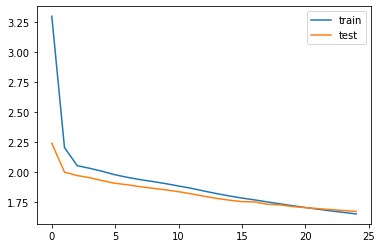

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend(9
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    print(target_seq)
    
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
columns=['Generated Text', 'Actual Text']
lst = []
for i in range(len(y_test)):
    orig_sum = seq2summary(y_test[i])
    predict_sum = decode_sequence(X_test[i].reshape(1,max_text_len))
    lst.append([orig_sum, predict_sum])
pre_df_seq = pd.DataFrame(lst, columns=columns)
pre_df_seq.head()

,Generated Text,Actual Text
0,Apple has traditionally done well in the marke...,Apple Mac mini gets warm welcome The Mac mini ...
1,Once several high profile legal cases against ...,Peer to peer nets here to stay Peer to peer P2...
2,Sonaptic has been working with Japanese mobile...,Mobile audio enters new dimension As mobile ph...
3,ICO 2 WORKING TITLE Ico remains an benchmark f...,The gaming world in 2005 If you have finished ...
4,The new strains of the Cabir mobile phone viru...,Fast moving phone viruses appear Security firm...


## Evaluation

In [ ]:
#Read data from prediction.csv file
pre_df_5 = pd.read_csv('predictions.csv')

In [ ]:
!pip install rouge
from rouge import Rouge 

In [ ]:
def assess(df_pre):

  #Initialization of an empty dict with the same "scores" structure that will be returned by the get_sores method
  eval = {
      'rouge-1':{
          'f':0,
          'p':0,
          'r':0
      },
      'rouge-2':{
          'f':0,
          'p':0,
          'r':0
      },
      'rouge-l':{
          'f':0,
          'p':0,
          'r':0
      }
  }

  #Add scores into the initialized dict
  for row in range(len(df_pre)):
    gen_text = df_pre.iloc[row,1]
    act_text = df_pre.iloc[row,2]
    rouge = Rouge()
    scores = rouge.get_scores(gen_text, act_text)
    eval['rouge-1']['f'] += scores[0]['rouge-1']['f']
    eval['rouge-1']['p'] += scores[0]['rouge-1']['p']
    eval['rouge-1']['r'] += scores[0]['rouge-1']['r']
    eval['rouge-2']['f'] += scores[0]['rouge-2']['f']
    eval['rouge-2']['p'] += scores[0]['rouge-2']['p']
    eval['rouge-2']['r'] += scores[0]['rouge-2']['r']
    eval['rouge-l']['f'] += scores[0]['rouge-l']['f']
    eval['rouge-l']['p'] += scores[0]['rouge-l']['p']
    eval['rouge-l']['r'] += scores[0]['rouge-l']['r']

    #Calculate the average value of all scores

  keys_list = eval.keys()
  list_of_metr = [eval.get(key) for key in keys_list]
  for metric in list_of_metr:
    for key in metric:
      metric[key] /= len(df_pre)

  eval_df = pd.DataFrame(data=eval)
  return eval_df

In [ ]:
# Evaluation for T5 Model
assess(pre_df_5)

,rouge-1,rouge-2,rouge-l
f,0.473113,0.264886,0.360899
p,0.466982,0.261457,0.338345
r,0.480166,0.268836,0.388521


In [ ]:
# Evaluation for Seq2Seq Model
assess(pre_df_seq)

,rouge-1,rouge-2,rouge-l
f,0.313407,0.192665,0.261685
p,0.608068,0.374702,0.389235
r,0.213577,0.131167,0.198545
